In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/srikaran')
os.getcwd()

'/content/drive/MyDrive/srikaran'

In [3]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

In [4]:
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp

In [5]:
# os.makedirs('/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets')

In [6]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/drive/My Drive/srikaran/gi-tract-image-segmentation/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [7]:
zip_path = '/content/drive/My Drive/srikaran/coco.zip'
extract_path = '/content/drive/My Drive/srikaran/gi-tract-image-segmentation/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [10]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')
os.getcwd()

'/content/drive/My Drive/srikaran/gi-tract-image-segmentation'

In [11]:
!ls datasets/train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [13]:
from src.data import SegmentationDataset
from src.data import DataGenerator
from src.model import SimpleUNet
from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [14]:
train_generator_class = DataGenerator(dataset_dir='/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/MyDrive/srikaran/gi-tract-image-segmentation/datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=1.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


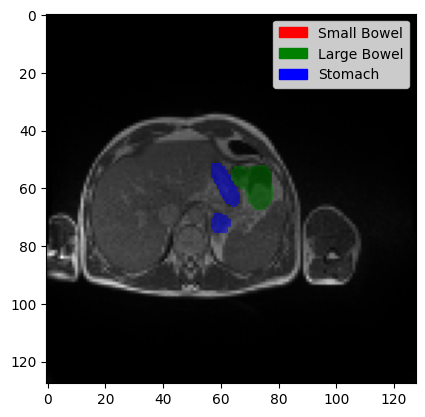

In [15]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(0)

plot_masks(X, y)

In [16]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()

    def forward(self, input, target):
        # Assumes input and target are of the same shape [batch_size, channels, height, width]
        batch_size = input.size(0)
        channels = input.size(1)
        iou_values_0 = []
        iou_values_1 = []
        iou_values_2 = []

        for i in range(batch_size):
            for ch in range(channels):
                input_flat = (input[i, ch] > 0.5).float()
                target_flat = (target[i, ch] > 0.5).float()

                if input_flat.sum() == 0 and target_flat.sum() == 0:
                    continue  # Skip channel if both input and target are all zeros

                intersection = (input_flat * target_flat).sum()
                union = (input_flat + target_flat).clamp(0, 1).sum()  # Use clamp to handle union calculation

                if union == 0:
                    iou = torch.tensor(0.)  # Avoid division by zero; can also return 1 if both masks are empty
                else:
                    iou = intersection / union

                # Append iou based on the channel
                if ch == 0:
                    iou_values_0.append(iou)
                elif ch == 1:
                    iou_values_1.append(iou)
                elif ch == 2:
                    iou_values_2.append(iou)

        # Calculate mean avoiding empty lists
        mean_iou_0 = torch.tensor(iou_values_0).mean() if iou_values_0 else torch.tensor(0.)
        mean_iou_1 = torch.tensor(iou_values_1).mean() if iou_values_1 else torch.tensor(0.)
        mean_iou_2 = torch.tensor(iou_values_2).mean() if iou_values_2 else torch.tensor(0.)

        return mean_iou_0, mean_iou_1, mean_iou_2

In [21]:
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)
criterion = CombinedLoss().to(device)

dice_criterion = DiceLoss().to(device)
hausdorff_dist_criterion = ChannelwiseHausdorffDistanceLoss().to(device)
iou_criterion = IoU().to(device)

In [22]:
train_losses = []
train_dice_losses = []
train_hausdorff_dist = []
train_iou_0 = [] # small bowel
train_iou_1 = [] # large bowel
train_iou_2 = [] # stomach


val_losses = []
val_dice_losses = []
val_hausdorff_dist = []
val_iou_0 = []
val_iou_1 = []
val_iou_2 = []

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    dice_loss_meter = AverageMeter()
    hausdorff_dist_meter = AverageMeter()
    iou_meter_0 = AverageMeter()
    iou_meter_1 = AverageMeter()
    iou_meter_2 = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        dice_loss_meter.update(dice_criterion(output, target).item(), data.size(0))
        hausdorff_dist_meter.update(hausdorff_dist_criterion(output, target).item(), data.size(0))

        iou_0, iou_1, iou_2 = iou_criterion(output, target)
        iou_meter_0.update(iou_0.item(), data.size(0))
        iou_meter_1.update(iou_1.item(), data.size(0))
        iou_meter_2.update(iou_2.item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_dice_losses.append(dice_loss_meter.avg)
    train_hausdorff_dist.append(hausdorff_dist_meter.avg)
    train_iou_0.append(iou_meter_0.avg)
    train_iou_1.append(iou_meter_1.avg)
    train_iou_2.append(iou_meter_2.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_dice_loss_meter = AverageMeter()
    val_hausdorff_dist_meter = AverageMeter()
    val_iou_meter_0 = AverageMeter()
    val_iou_meter_1 = AverageMeter()
    val_iou_meter_2 = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            val_dice_loss_meter.update(dice_criterion(output, target).item(), data.size(0))
            val_hausdorff_dist_meter.update(hausdorff_dist_criterion(output, target).item(), data.size(0))

            iou_0, iou_1, iou_2 = iou_criterion(output, target)
            val_iou_meter_0.update(iou_0.item(), data.size(0))
            val_iou_meter_1.update(iou_1.item(), data.size(0))
            val_iou_meter_2.update(iou_2.item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_dice_losses.append(val_dice_loss_meter.avg)
    val_hausdorff_dist.append(val_hausdorff_dist_meter.avg)
    val_iou_0.append(val_iou_meter_0.avg)
    val_iou_1.append(val_iou_meter_1.avg)
    val_iou_2.append(val_iou_meter_2.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, \
            Train Dice: {dice_loss_meter.avg:.4f}, Val Dice: {val_dice_loss_meter.avg:.4f} \
            Train Hausdorff: {hausdorff_dist_meter.avg:.4f}, Val Hausdorff: {val_hausdorff_dist_meter.avg:.4f} \
            Train IOU SB: {iou_meter_0.avg:.4f}, Val IOU SB: {val_iou_meter_0.avg:.4f} \
            Train IOU LB: {iou_meter_1.avg:.4f}, Val IOU LB: {val_iou_meter_1.avg:.4f} \
            Train IOU S: {iou_meter_2.avg:.4f}, Val IOU S: {val_iou_meter_2.avg:.4f}')

    # Save model checkpoint
    torch.save(model.state_dict(), f'Large_UNET_model_epoch_{epoch}.pth')

Epoch 0 Validation: 100%|██████████| 145/145 [02:00<00:00,  1.21it/s]


Epoch 0: Train Loss: 2.6906, Val Loss: 2.1155,             Train Dice: 0.3355, Val Dice: 0.3673             Train Hausdorff: 4.2607, Val Hausdorff: 3.2810             Train IOU SB: 0.0203, Val IOU SB: 0.0000             Train IOU LB: 0.3634, Val IOU LB: 0.3073             Train IOU S: 0.3304, Val IOU S: 0.3260


Epoch 1 Validation: 100%|██████████| 145/145 [01:56<00:00,  1.25it/s]


Epoch 1: Train Loss: 2.2738, Val Loss: 2.1025,             Train Dice: 0.1716, Val Dice: 0.3575             Train Hausdorff: 3.6752, Val Hausdorff: 3.2659             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.4755, Val IOU LB: 0.3177             Train IOU S: 0.4851, Val IOU S: 0.3351


Epoch 2 Validation: 100%|██████████| 145/145 [01:56<00:00,  1.24it/s]


Epoch 2: Train Loss: 2.2297, Val Loss: 2.1198,             Train Dice: 0.1488, Val Dice: 0.3255             Train Hausdorff: 3.6170, Val Hausdorff: 3.3159             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5008, Val IOU LB: 0.3319             Train IOU S: 0.5211, Val IOU S: 0.3116


Epoch 3 Validation: 100%|██████████| 145/145 [01:56<00:00,  1.24it/s]


Epoch 3: Train Loss: 2.2097, Val Loss: 2.0936,             Train Dice: 0.1361, Val Dice: 0.3111             Train Hausdorff: 3.5922, Val Hausdorff: 3.2818             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5151, Val IOU LB: 0.3414             Train IOU S: 0.5418, Val IOU S: 0.3302


Epoch 4 Validation: 100%|██████████| 145/145 [01:57<00:00,  1.23it/s]


Epoch 4: Train Loss: 2.1982, Val Loss: 2.0764,             Train Dice: 0.1294, Val Dice: 0.3223             Train Hausdorff: 3.5773, Val Hausdorff: 3.2458             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5258, Val IOU LB: 0.3332             Train IOU S: 0.5465, Val IOU S: 0.3679


Epoch 5 Validation: 100%|██████████| 145/145 [01:57<00:00,  1.24it/s]


Epoch 5: Train Loss: 2.1805, Val Loss: 2.0534,             Train Dice: 0.1205, Val Dice: 0.3104             Train Hausdorff: 3.5539, Val Hausdorff: 3.2154             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5348, Val IOU LB: 0.3452             Train IOU S: 0.5663, Val IOU S: 0.3904


Epoch 6 Validation: 100%|██████████| 145/145 [01:57<00:00,  1.23it/s]


Epoch 6: Train Loss: 2.1790, Val Loss: 2.0451,             Train Dice: 0.1176, Val Dice: 0.3090             Train Hausdorff: 3.5533, Val Hausdorff: 3.2025             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5390, Val IOU LB: 0.3513             Train IOU S: 0.5662, Val IOU S: 0.3944


Epoch 7 Validation: 100%|██████████| 145/145 [01:56<00:00,  1.24it/s]


Epoch 7: Train Loss: 2.1655, Val Loss: 2.0533,             Train Dice: 0.1112, Val Dice: 0.3143             Train Hausdorff: 3.5350, Val Hausdorff: 3.2126             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5474, Val IOU LB: 0.3560             Train IOU S: 0.5812, Val IOU S: 0.3755


Epoch 8 Validation: 100%|██████████| 145/145 [01:57<00:00,  1.23it/s]


Epoch 8: Train Loss: 2.1588, Val Loss: 2.0772,             Train Dice: 0.1082, Val Dice: 0.3112             Train Hausdorff: 3.5259, Val Hausdorff: 3.2546             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5508, Val IOU LB: 0.3487             Train IOU S: 0.5913, Val IOU S: 0.3588


Epoch 9 Validation: 100%|██████████| 145/145 [01:56<00:00,  1.24it/s]


Epoch 9: Train Loss: 2.1566, Val Loss: 2.0926,             Train Dice: 0.1055, Val Dice: 0.3112             Train Hausdorff: 3.5241, Val Hausdorff: 3.2802             Train IOU SB: 0.0000, Val IOU SB: 0.0000             Train IOU LB: 0.5542, Val IOU LB: 0.3473             Train IOU S: 0.5892, Val IOU S: 0.3405


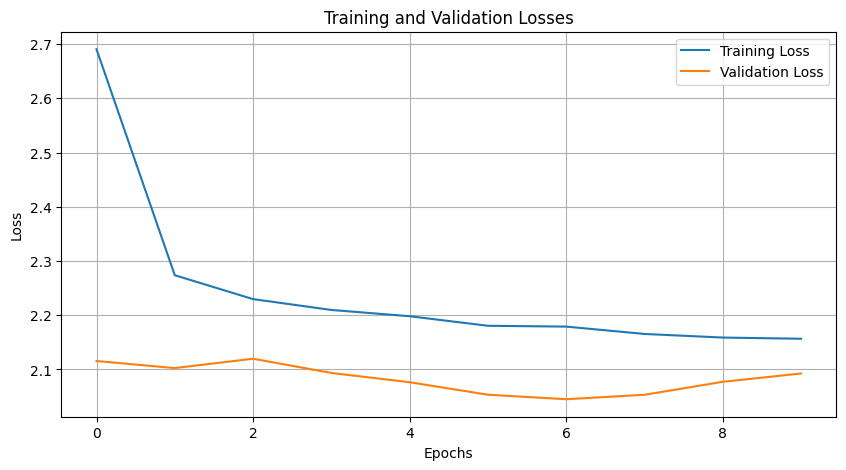

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

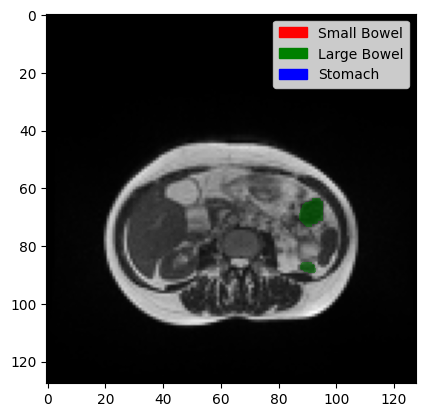

In [24]:
X, y = test_generator_class.__getitem__(9)

plot_masks(X, y)

In [25]:
!ls

config.py		      Large_UNET_model_epoch_4.pth  LICENSE
datasets		      Large_UNET_model_epoch_5.pth  notebooks
Large_UNET_model_epoch_0.pth  Large_UNET_model_epoch_6.pth  README.md
Large_UNET_model_epoch_1.pth  Large_UNET_model_epoch_7.pth  requirements.txt
Large_UNET_model_epoch_2.pth  Large_UNET_model_epoch_8.pth  src
Large_UNET_model_epoch_3.pth  Large_UNET_model_epoch_9.pth  temp_json.json


In [26]:
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('Large_UNET_model_epoch_6.pth'))

# Set the model to evaluation mode if you are making predictions
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [27]:
images_test = []
predictions = []
masks = []
# No need to track gradients here
with torch.no_grad():
    for data in test_loader:
        # Assuming your DataLoader returns a tuple of (images, labels)
        images = data[0]
        images = images.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # Generate predictions
        output = model(images).permute(0, 2, 3, 1)
        predictions.append(output)

        mask = data[1].permute(0, 3, 1, 2).to(device)
        masks.append(mask)

In [31]:
img_s = images_test[0]
pred_s = predictions[0]
mask_s = masks[0]

pred_s.size(), mask_s.size(), img_s.size()

(torch.Size([32, 128, 128, 3]),
 torch.Size([32, 3, 128, 128]),
 torch.Size([32, 3, 128, 128]))

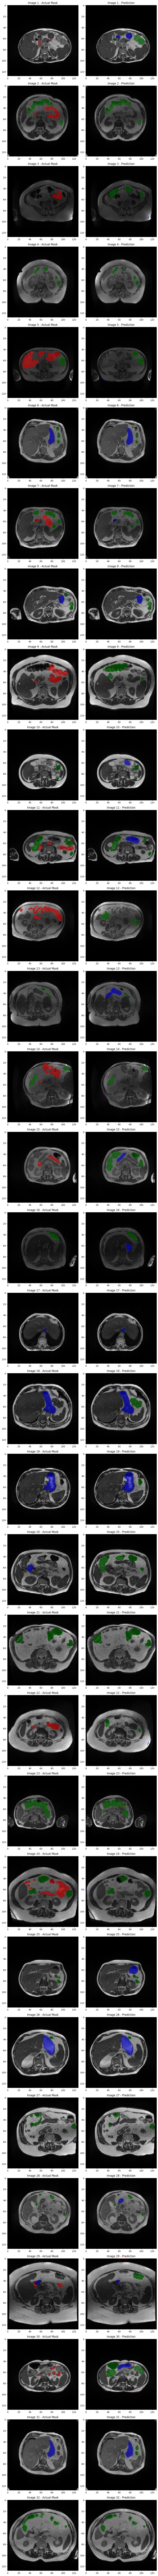

In [33]:
from src.utils.plot_utils import display_comparison

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())

In [36]:
print(train_losses)
print(train_dice_losses)
print(train_hausdorff_dist)
print(train_iou_0)
print(train_iou_1)
print(train_iou_2)


print(val_losses)
print(val_dice_losses)
print(val_hausdorff_dist)
print(val_iou_0)
print(val_iou_1)
print(val_iou_2)

[2.690626744788465, 2.273790753112939, 2.229723212089715, 2.2097474704300173, 2.1981529327908382, 2.1805423104884043, 2.1790185545455296, 2.1654785132884076, 2.1588080682673896, 2.156632062783781]
[0.33547830008889495, 0.17163163870187892, 0.14883568332535374, 0.13608461838595776, 0.1293655405156117, 0.12050670167099051, 0.11763594226891066, 0.11118494845300632, 0.10817086777449711, 0.10549175906932819]
[4.260725707921508, 3.6752301627203154, 3.6169815645992895, 3.5921893717927214, 3.5773445276409905, 3.5538993830333445, 3.5532736293966103, 3.535007556512007, 3.5258995352626537, 3.5240589319267457]
[0.020287144145241628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.3634311967331657, 0.47549914058259496, 0.5008456669656453, 0.5151409554543329, 0.525777130120186, 0.5348492845004205, 0.5389603375720196, 0.5474469956811822, 0.5508358280525385, 0.5542118786800567]
[0.33043001154074114, 0.4850954754775805, 0.5210784178670231, 0.5418150990656274, 0.546518753241019, 0.5663035929921514, 0.56